In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd # GeoPandas library for spatial analytics
from shapely.geometry import shape
import folium
import plotly.graph_objects as go
from urllib.parse import urlencode
import urllib.request, json 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns # visualization styling package
%matplotlib inline 
import os 
from pandas.api.types import CategoricalDtype
import contextily as ctx
from shapely.geometry import Point
from shapely.geometry import LineString
from geopy import distance
pd.set_option('display.max_columns', None)


In [4]:
bus_positions = pd.read_csv("./Bus_Data/2023-05-17-bus-positions.csv")
bus_positions_B41 = bus_positions[bus_positions["route_id"] == 'B41']
geometry = [Point(xy) for xy in zip(bus_positions_B41['longitude'], bus_positions_B41['latitude'])]
gdf = gpd.GeoDataFrame(bus_positions_B41, geometry=geometry)
gdf.crs = 'EPSG:4326'  # Assuming WGS84 coordinate system (latitude/longitude)

In [5]:
# Convert 'timestamp' column to datetime format
gdf['timestamp'] = pd.to_datetime(gdf['timestamp'])
gdf['hour'] = gdf['timestamp'].dt.hour
gdf = gdf.to_crs("EPSG:32618")  # Convert CRS to a suitable projection for distance calculations (e.g., UTM)

grouped = gdf.groupby(['hour', 'trip_id'])

lines = []
lengths = []
hours = []
trip_ids = []
earliest_timestamps = []
latest_timestamps = []
time_differences = []
speeds = []

for name, group in grouped:
    if len(group) >= 2:  # Ensure at least two points exist for a line
        hour = name[0]  # Extract the hour from the group key
        trip_id = name[1]  # Extract the trip_id from the group key
        line = LineString(group['geometry'].tolist())
        length_meters = line.length  # Calculate the length of LineString in meters
        length_miles = distance.distance(meters=length_meters).miles  # Convert length from meters to miles
        lines.append(line)
        lengths.append(length_miles)
        hours.append(hour)
        trip_ids.append(trip_id)
        earliest_timestamp = group['timestamp'].min()  # Get the earliest timestamp
        latest_timestamp = group['timestamp'].max()  # Get the latest timestamp
        time_difference = latest_timestamp - earliest_timestamp  # Calculate the time difference
        speed = length_miles / time_difference.total_seconds() * 3600 # Calculate the speed in miles per second
        earliest_timestamps.append(earliest_timestamp)
        latest_timestamps.append(latest_timestamp)
        time_differences.append(time_difference)
        speeds.append(speed)

df = pd.DataFrame({
    'hour': hours,
    'trip_id': trip_ids,
    'length_miles': lengths,
    'earliest_timestamp': earliest_timestamps,
    'latest_timestamp': latest_timestamps,
    'time_difference': time_differences,
    'speed_mph': speeds
})

df

,hour,trip_id,length_miles,earliest_timestamp,latest_timestamp,time_difference,speed_mph
0,0,FB_B3-Weekday-SDon-111500_B41_266,0.014850,2023-05-17 00:01:42+00:00,2023-05-17 00:05:42+00:00,0 days 00:04:00,0.222756
1,0,FB_B3-Weekday-SDon-111900_B41_275,0.079170,2023-05-17 00:03:24+00:00,2023-05-17 00:15:37+00:00,0 days 00:12:13,0.388832
2,0,FB_B3-Weekday-SDon-112100_B41_276,0.035581,2023-05-17 00:01:33+00:00,2023-05-17 00:03:36+00:00,0 days 00:02:03,1.041395
3,0,FB_B3-Weekday-SDon-112300_B41_256,0.149216,2023-05-17 00:01:43+00:00,2023-05-17 00:07:19+00:00,0 days 00:05:36,1.598747
4,0,FB_B3-Weekday-SDon-112400_B41_268,0.050280,2023-05-17 00:01:50+00:00,2023-05-17 00:15:42+00:00,0 days 00:13:52,0.217557
...,...,...,...,...,...,...,...
1017,23,FB_B3-Weekday-SDon-118200_B41_282,1.139340,2023-05-17 23:49:42+00:00,2023-05-17 23:59:21+00:00,0 days 00:09:39,7.083980
1018,23,FB_B3-Weekday-SDon-118400_B41_265,2.334078,2023-05-17 23:33:46+00:00,2023-05-17 23:59:16+00:00,0 days 00:25:30,5.491948
1019,23,FB_B3-Weekday-SDon-118800_B41_252,1.138613,2023-05-17 23:47:33+00:00,2023-05-17 23:59:15+00:00,0 days 00:11:42,5.839041
1020,23,FB_B3-Weekday-SDon-119000_B41_284,0.913211,2023-05-17 23:47:38+00:00,2023-05-17 23:59:21+00:00,0 days 00:11:43,4.676474


In [6]:
df.describe()

,hour,length_miles,time_difference,speed_mph
count,1022.000000,1022.000000,1022,1022.000000
mean,14.241683,4.345031,0 days 00:33:01.522504892,7.260295
std,6.454641,4.990053,0 days 00:18:07.691198805,6.567367
min,0.000000,0.000000,0 days 00:01:00,0.000000
25%,11.000000,1.309379,0 days 00:17:45,4.355857
50%,15.000000,3.485631,0 days 00:34:00,6.380542
75%,19.000000,5.750332,0 days 00:49:59.750000,8.357089
max,23.000000,68.086032,0 days 00:58:32,71.565967


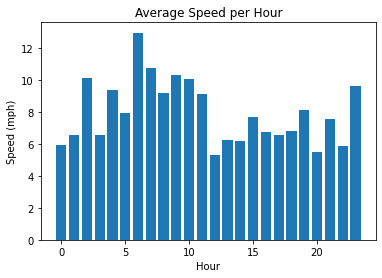

In [45]:
#import matplotlib.pyplot as plt

# Group the DataFrame by "hour" and calculate the mean speed for each hour
hourly_speeds = df.groupby('hour')['speed_mph'].mean()

# Create the bar chart
plt.bar(hourly_speeds.index, hourly_speeds.values)
plt.xlabel('Hour')
plt.ylabel('Speed (mph)')
plt.title('Average Speed per Hour')
plt.show()
